## Modelo Machine Learning: Classificação

### Instalação das bibliotecas necessárias

In [1]:
pip install boto3 -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install sklearn -q

Note: you may need to restart the kernel to use updated packages.


### Importação das bibliotecas necessárias

In [3]:
import boto3
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

### Conexão com o S3

In [4]:
# Credenciais da conta a ser utilizada
AWS_S3_CREDS = {
    "aws_access_key_id":"*", # os.getenv("AWS_ACCESS_KEY")
    "aws_secret_access_key":"*" # os.getenv("AWS_SECRET_KEY")
}

In [5]:
# Instanciação de um objeto cliente do S3
s3 = boto3.client('s3', region_name='us-east-1', **AWS_S3_CREDS)

### Recuperação dos dados

In [6]:
# Nome do bucket em que os dados estão armazenados
bucket_name='cleaned-larissa'

In [7]:
result = s3.list_objects(Bucket = bucket_name)

In [8]:
# Array que armazenará o conteúdo do bucket
conteudo = []
for o in result.get('Contents'):
    data = s3.get_object(Bucket=bucket_name, Key=o.get('Key'))
    contents = data['Body'].read().decode()
    for linha in contents.split('\n'):
        conteudo.append(linha.split(','))

In [9]:
# Header do arquivo
header = ["id","name","abv","ibu","target_fg","target_og","ebc","srm","ph"]

In [10]:
# Transforma a lista em um dataframe pandas
df = pd.DataFrame(conteudo, columns=header)

### Tratamento dos dados

In [11]:
# Conversões do tipo de dados
df['id'] = pd.to_numeric(df["id"])
df['abv'] = pd.to_numeric(df["abv"])
df['target_fg'] = pd.to_numeric(df["target_fg"])
df['target_og'] = pd.to_numeric(df["target_og"])
df['ebc'] = pd.to_numeric(df["ebc"])
df['srm'] = pd.to_numeric(df["srm"])
df['ph'] = pd.to_numeric(df["ph"])

In [12]:
# Exclusão de registros que possuam colunas sem preenchimento
df = df.dropna()

### Determinação de features e target

In [14]:
# Features do modelo
features_nome = ['abv', 'target_fg', 'target_og', 'ebc', 'srm', 'ph']
# Target do modelo
target_nome = ['ibu']

### Separação de treino e teste

In [15]:
# Separa os dados para treino e teste do modelo
X_train, X_test, y_train, y_test = train_test_split(df[features_nome]\
                                                    , df[target_nome]\
                                                    , test_size=0.5\
                                                    , stratify=df[target_nome]\
                                                    , random_state=123456)

### Treino do modelo

In [16]:
forest = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123456)
forest.fit(X_train, y_train.values.ravel())

RandomForestClassifier(oob_score=True, random_state=123456)

### Execução do modelo

In [17]:
predicted = forest.predict(X_test)

### Avaliação do modelo

In [18]:
accuracy = accuracy_score(y_test, predicted)
print(f'Out-of-bag score estimate: {forest.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')

Out-of-bag score estimate: 1.0
Mean accuracy score: 1.0


In [19]:
cm = pd.DataFrame(confusion_matrix(y_test, predicted)\
                  , columns=y_test['ibu'].unique().tolist()
                  , index=y_test['ibu'].unique().tolist())

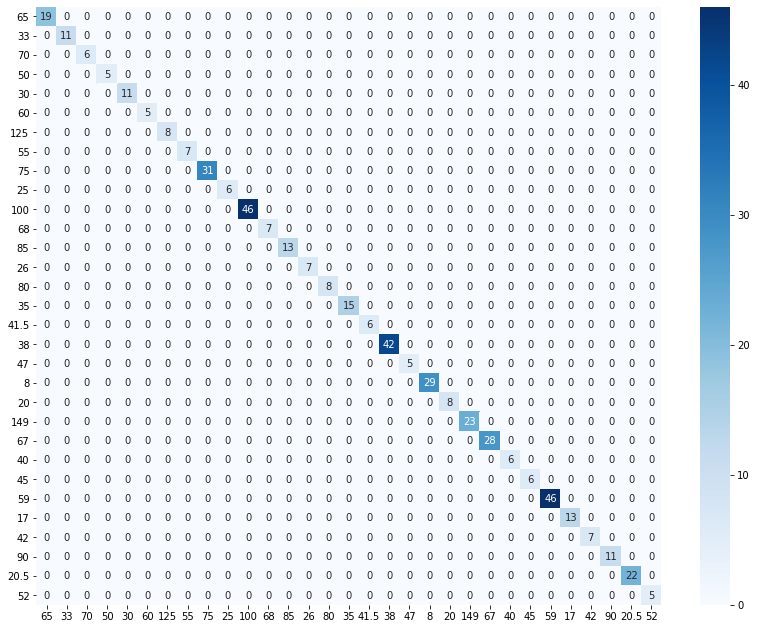

In [20]:
fig, ax = plt.subplots(figsize=(14, 11))
sns.heatmap(cm, annot=True,cmap='Blues')
plt.show()